# 1. Read Data

In [1]:
# Load data
import os
import pandas as pd
import glob
import json
import numpy as np
import seaborn as sns
import gc
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import BallTree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tqdm
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input, Model
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

# Confirm the current working directory
print("Current working directory:", os.getcwd())

2025-07-02 13:43:40.480511: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Current working directory: /home/qusta100/Gasoline


In [3]:
# Load data (restore from saved file)
recovery = pd.read_csv("Data/Temp/final.csv")

# 2. Model Estimation

In [4]:
# Create Sample

# 1. Extract only unique stations with coordinates
stations_all = recovery[['station_uuid', 'latitude', 'longitude']].drop_duplicates()

# 2. Randomly select 500 seed stations and mark them
sample_stations = stations_all.sample(n=500, random_state=42)
sample_stations['is_seed'] = True

# 3. Add seed marker to all stations
stations = stations_all.merge(
    sample_stations[['station_uuid', 'is_seed']],
    on='station_uuid',
    how='left'
)
stations['is_seed'] = stations['is_seed'].fillna(False).astype(bool)
stations = stations.set_index('station_uuid')  # important: set index

# 4. Filter time series data
df_filtered = recovery.copy()

# 5. Statistics
print("Filtering completed:")
print(" - Seed stations:", stations['is_seed'].sum())
print(" - Total Stations:", df_filtered['station_uuid'].nunique())
print(" - Observations in dataset:", len(df_filtered))

/var/tmp/pbs.14231961.hpc-batch/ipykernel_126584/1204449145.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  stations['is_seed'] = stations['is_seed'].fillna(False).astype(bool)


Filtering completed:
 - Seed stations: 500
 - Total Stations: 15093
 - Observations in dataset: 43320521


In [5]:
# ==========================
# 1. Parameters
# ==========================
window_size = 96
forecast_horizon = 8
target_cols = [f'rank_e5_5km+{i}' for i in range(1, forecast_horizon + 1)]
feature_cols = ['diesel', 'e5', 'e10']
radius_km = 5
max_neighbors = 5  # +1 for target station = 6 in total

# ==========================
# 2. Prepare Data
# ==========================
df = df_filtered.copy()
df['date'] = pd.to_datetime(df['date'])

if 'station_uuid' in stations.columns:
    stations = stations.set_index('station_uuid')

coords_rad = np.radians(stations[['latitude', 'longitude']].values)
tree = BallTree(coords_rad, metric='haversine')

df_pivot_all = df.pivot_table(index='date', columns='station_uuid', values=feature_cols)
df_pivot_all = df_pivot_all.sort_index()

# ==========================
# 3. Feature engineering function for a single station
# ==========================
def process_station(station_id, coords):
    try:
        # a) Find nearest neighbors including the target station
        dist, ind = tree.query_radius(
            np.radians([[coords['latitude'], coords['longitude']]]),
            r=radius_km / 6371.0,
            return_distance=True,
            sort_results=True
        )
        neighbor_ids = stations.iloc[ind[0]].index.tolist()

        if station_id in neighbor_ids:
            neighbor_ids.remove(station_id)
        neighbor_ids = [station_id] + neighbor_ids[:max_neighbors]
        while len(neighbor_ids) < max_neighbors + 1:
            neighbor_ids.append(f'dummy_{len(neighbor_ids)}')

        # d) Extract price data & add dummy columns with NaN
        df_pivot = df_pivot_all.copy()
        for dummy_id in [sid for sid in neighbor_ids if sid.startswith("dummy_")]:
            for feature in feature_cols:
                df_pivot[(feature, dummy_id)] = np.nan

        mi = pd.MultiIndex.from_product([feature_cols, neighbor_ids])
        df_pivot = df_pivot.reindex(columns=mi, fill_value=np.nan)

        # e) Target values for the target station
        df_target = df[df['station_uuid'] == station_id].set_index('date').sort_index()
        missing_targets = [col for col in target_cols if col not in df_target.columns]
        if missing_targets:
            print(f"Station {station_id} missing target_cols: {missing_targets}")
            return [], []

        df_target = df_target[target_cols]

        # f) Scale values (column-wise)
        raw_values = df_pivot.values
        mask_nan = np.isnan(raw_values)
        raw_values_scaled = raw_values.copy()
        for col_idx in range(raw_values.shape[1]):
            col = raw_values[:, col_idx]
            not_nan = ~mask_nan[:, col_idx]
            if np.any(not_nan):
                scaler = MinMaxScaler()
                col_scaled = scaler.fit_transform(col[not_nan].reshape(-1, 1)).ravel()
                raw_values_scaled[not_nan, col_idx] = col_scaled
        raw_values_scaled[mask_nan] = np.nan

        n_time = df_pivot.shape[0]
        X_scaled = raw_values_scaled.reshape(
            n_time,
            max_neighbors + 1,
            len(feature_cols)
        )

        # g) Sliding window
        X_list, y_list = [], []
        for i in range(n_time - window_size - forecast_horizon + 1):
            X_seq = X_scaled[i : i + window_size]
            y_window = df_target.iloc[i + window_size : i + window_size + forecast_horizon][target_cols].values
            y_seq = y_window[range(forecast_horizon), range(forecast_horizon)]
            assert y_seq.shape == (forecast_horizon,), f"Incorrect target shape: {y_seq.shape}"
            X_list.append(X_seq)
            y_list.append(y_seq)

        return X_list, y_list

    except Exception as e:
        print(f"Error with station {station_id}: {e}")
        return [], []

# ==========================
# 4. Parallel Processing
# ==========================
def parallel_feature_engineering(seed_stations, batch_size=20, n_jobs=None):
    if n_jobs is None:
        n_jobs = min(8, os.cpu_count() - 1)
    X_all, y_all = [], []

    for start in range(0, len(seed_stations), batch_size):
        end = min(start + batch_size, len(seed_stations))
        batch = seed_stations.iloc[start:end]
        print(f"\nProcessing stations {start+1} to {end} of {len(seed_stations)} ...")
        results = Parallel(n_jobs=n_jobs)(
            delayed(process_station)(station_id, coords)
            for station_id, coords in tqdm(batch.iterrows(), total=len(batch))
        )
        for X_part, y_part in results:
            X_all.extend(X_part)
            y_all.extend(y_part)
        print(f"Progress: {len(X_all)} windows collected")
    return np.array(X_all), np.array(y_all)

# ==========================
# 5. Start Feature Engineering
# ==========================
seed_stations = stations[stations['is_seed']].copy()
X_final, y_final = parallel_feature_engineering(seed_stations, batch_size=20, n_jobs=6)

print("Parallelization complete!")
print("X_final shape:", X_final.shape)
print("y_final shape:", y_final.shape)

# ==========================
# 6. Postprocessing / NaN filtering
# ==========================
nan_ratio_X = np.isnan(X_final).mean(axis=(1,2,3))
nan_ratio_y = np.isnan(y_final).mean(axis=1)
valid_idx = np.where((nan_ratio_X < 0.2) & (nan_ratio_y == 0))[0]
X_final_clean = X_final[valid_idx]
y_final_clean = y_final[valid_idx]

print(f"Valid training windows: {len(X_final_clean)} of {len(X_final)}")
print("Feature engineering completed!")
print(f"X_final_clean shape: {X_final_clean.shape}")
print(f"y_final_clean shape: {y_final_clean.shape}")


Processing stations 1 to 20 of 500 ...


  0%|          | 0/20 [00:00<?, ?it/s]

Progress: 55380 windows collected

Processing stations 21 to 40 of 500 ...


  0%|          | 0/20 [00:00<?, ?it/s]

Progress: 110760 windows collected

Processing stations 41 to 60 of 500 ...


  0%|          | 0/20 [00:00<?, ?it/s]

Progress: 166140 windows collected

Processing stations 61 to 80 of 500 ...


  0%|          | 0/20 [00:00<?, ?it/s]

Progress: 221520 windows collected

Processing stations 81 to 100 of 500 ...


  0%|          | 0/20 [00:00<?, ?it/s]

Progress: 276900 windows collected

Processing stations 101 to 120 of 500 ...


  0%|          | 0/20 [00:00<?, ?it/s]

Progress: 329511 windows collected

Processing stations 121 to 140 of 500 ...


  0%|          | 0/20 [00:00<?, ?it/s]

Progress: 382122 windows collected

Processing stations 141 to 160 of 500 ...


  0%|          | 0/20 [00:00<?, ?it/s]

Progress: 437502 windows collected

Processing stations 161 to 180 of 500 ...


  0%|          | 0/20 [00:00<?, ?it/s]

Progress: 492882 windows collected

Processing stations 181 to 200 of 500 ...


  0%|          | 0/20 [00:00<?, ?it/s]

Progress: 548262 windows collected

Processing stations 201 to 220 of 500 ...


  0%|          | 0/20 [00:00<?, ?it/s]

Progress: 603642 windows collected

Processing stations 221 to 240 of 500 ...


  0%|          | 0/20 [00:00<?, ?it/s]

Progress: 659022 windows collected

Processing stations 241 to 260 of 500 ...


  0%|          | 0/20 [00:00<?, ?it/s]

Progress: 714402 windows collected

Processing stations 261 to 280 of 500 ...


  0%|          | 0/20 [00:00<?, ?it/s]

Progress: 769782 windows collected

Processing stations 281 to 300 of 500 ...


  0%|          | 0/20 [00:00<?, ?it/s]

Progress: 822393 windows collected

Processing stations 301 to 320 of 500 ...


  0%|          | 0/20 [00:00<?, ?it/s]

Progress: 877773 windows collected

Processing stations 321 to 340 of 500 ...


  0%|          | 0/20 [00:00<?, ?it/s]

Progress: 933153 windows collected

Processing stations 341 to 360 of 500 ...


  0%|          | 0/20 [00:00<?, ?it/s]

Progress: 988533 windows collected

Processing stations 361 to 380 of 500 ...


  0%|          | 0/20 [00:00<?, ?it/s]

Progress: 1043913 windows collected

Processing stations 381 to 400 of 500 ...


  0%|          | 0/20 [00:00<?, ?it/s]

Progress: 1099293 windows collected

Processing stations 401 to 420 of 500 ...


  0%|          | 0/20 [00:00<?, ?it/s]

Progress: 1154673 windows collected

Processing stations 421 to 440 of 500 ...


  0%|          | 0/20 [00:00<?, ?it/s]

Progress: 1210053 windows collected

Processing stations 441 to 460 of 500 ...


  0%|          | 0/20 [00:00<?, ?it/s]

Progress: 1265433 windows collected

Processing stations 461 to 480 of 500 ...


  0%|          | 0/20 [00:00<?, ?it/s]

Progress: 1320813 windows collected

Processing stations 481 to 500 of 500 ...


  0%|          | 0/20 [00:00<?, ?it/s]

Progress: 1373424 windows collected
Parallelization complete!
X_final shape: (1373424, 96, 6, 3)
y_final shape: (1373424, 8)
Valid training windows: 625928 of 1373424
Feature engineering completed!
X_final_clean shape: (625928, 96, 6, 3)
y_final_clean shape: (625928, 8)


In [6]:
# Previous check for NaNs in the cleaned arrays
print("Total NaNs in X_final_clean:", np.isnan(X_final_clean).sum(), "out of", X_final_clean.size)
print("Total NaNs in y_final_clean:", np.isnan(y_final_clean).sum(), "out of", y_final_clean.size)

Total NaNs in X_final_clean: 40715608 out of 1081603584
Total NaNs in y_final_clean: 0 out of 5007424


In [7]:
# Save features/targets
np.save("Data/Temp/X_final_clean.npy", X_final_clean)
np.save("Data/Temp/y_final_clean.npy", y_final_clean)

Error with station 8a796af1-8d78-4148-866d-8327ce46c45b: index 7 is out of bounds for axis 0 with size 7
Error with station f1251e4c-647f-43cf-9654-345961cce015: index 7 is out of bounds for axis 0 with size 7
Error with station 2ae5b659-890e-4ef9-84b1-0b575b616d78: index 7 is out of bounds for axis 0 with size 7
Error with station 35529319-e19c-41ef-83da-d9dcdfb02704: index 7 is out of bounds for axis 0 with size 7


In [9]:
# Load features/targets
X_final_clean = np.load("Data/Temp/X_final_clean.npy")
y_final_clean = np.load("Data/Temp/y_final_clean.npy")

In [4]:
# Split in Training und Test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_final_clean, y_final_clean, test_size=0.2, random_state=42
)

# Hyperparameter wie im Paper
conv_filters = 64      # statt 512
kernel_size = 3
lstm_units = 64        # statt 512
pool_sizes = [(3,), (2,)]
dense_units = [128, 64, 32]   # statt 512,256,128,64,32

learning_rate = 3e-4

# ==== NEU: reshape falls nötig ====
# Beispiel: X_train.shape = (n_samples, 96, 6, 3)  # 6 Stationen, 3 Features pro Station
if len(X_train.shape) == 4:
    # Kombiniere Stationen und Features zu einer Feature-Dimension:
    X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2] * X_train.shape[3])
    X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2] * X_test.shape[3])
else:
    X_train_reshaped = X_train
    X_test_reshaped = X_test
    
X_train_reshaped = np.nan_to_num(X_train_reshaped, nan=0.0, posinf=0.0, neginf=0.0)
X_test_reshaped = np.nan_to_num(X_test_reshaped, nan=0.0, posinf=0.0, neginf=0.0)

print("X_train_reshaped.shape:", X_train_reshaped.shape)

input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])  # (timesteps, features)
output_dim = y_train.shape[1]  # Multi-Step Output (z. B. 10 Tage)

inputs = Input(shape=input_shape)

# 1. CNN-Block
x = layers.Conv1D(conv_filters, kernel_size, padding='same', activation='relu')(inputs)
x = layers.MaxPooling1D(pool_size=pool_sizes[0][0])(x)
x = layers.Conv1D(conv_filters, kernel_size, padding='same', activation='relu')(x)
x = layers.MaxPooling1D(pool_size=pool_sizes[1][0])(x)
cnn_out = layers.Flatten()(x)  # flach für dense layers

# 2. LSTM-Block
lstm_x = layers.LSTM(lstm_units, return_sequences=True)(inputs)
lstm_x = layers.LSTM(lstm_units, return_sequences=False)(lstm_x)
# lstm_x ist schon flach

# 3. Skip-Connection (Concatenate CNN- und LSTM-Block)
concat = layers.Concatenate()([cnn_out, lstm_x])

# 4. Dense Layers mit LeakyReLU
d = concat
for units in dense_units:
    d = layers.Dense(units)(d)
    d = layers.LeakyReLU()(d)

# 5. Output-Layer (Linear)
outputs = layers.Dense(output_dim)(d)

model = Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mse',
    metrics=['mae']
)

model.summary()

# Training wie gehabt
history = model.fit(
    X_train_reshaped, y_train,
    validation_data=(X_test_reshaped, y_test),
    epochs=10,       # Passe an!
    batch_size=128,
    verbose=1
)

loss, mae = model.evaluate(X_test_reshaped, y_test)
print("Test Loss:", loss)
print("Test MAE:", mae)


X_train_reshaped.shape: (170077, 96, 18)


2025-06-29 18:47:01.646995: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2025-06-29 18:47:02.316923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-06-29 18:47:02.318039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-06-29 18:47:02.3

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 18)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 96, 64)       3520        ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 32, 64)       0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 32, 64)       12352       ['max_pooling1d[0][0]']          
                                                                                              

2025-06-29 18:47:03.488651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-06-29 18:47:03.489846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-06-29 18:47:03.490877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1329/1329 [==============================] - ETA: 0s - loss: 36.5075 - mae: 4.3206

2025-06-29 18:51:56.861631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-06-29 18:51:56.862974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-06-29 18:51:56.863868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1329/1329 [==============================] - 320s 238ms/step - loss: 36.5075 - mae: 4.3206 - val_loss: 31.9023 - val_mae: 4.0626
Epoch 2/10
1329/1329 [==============================] - 325s 245ms/step - loss: 28.1284 - mae: 3.7292 - val_loss: 24.4823 - val_mae: 3.3513
Epoch 3/10
1329/1329 [==============================] - 322s 242ms/step - loss: 23.1467 - mae: 3.3466 - val_loss: 20.2390 - val_mae: 3.1543
Epoch 4/10
1329/1329 [==============================] - 334s 251ms/step - loss: 19.9843 - mae: 3.0865 - val_loss: 18.7450 - val_mae: 2.8632
Epoch 5/10
1329/1329 [==============================] - 334s 251ms/step - loss: 17.7452 - mae: 2.8933 - val_loss: 18.4600 - val_mae: 2.8062
Epoch 6/10
1329/1329 [==============================] - 343s 258ms/step - loss: 15.8667 - mae: 2.7261 - val_loss: 15.5686 - val_mae: 2.6730
Epoch 7/10
1329/1329 [==============================] - 322s 242ms/step - loss: 14.4232 - mae: 2.5963 - val_loss: 13.7615 - val_mae: 2.5792
Epoch 8/10
1329/1329 [=========

In [6]:
# Save model and test data
model.save("Data/Temp/my_model.keras")

np.save('Data/Temp/X_test.npy', X_test)
np.save('Data/Temp/y_test.npy', y_test)
np.save('Data/Temp/X_train_reshaped.npy', X_train_reshaped)
np.save('Data/Temp/X_train_reshaped.npy', X_test_reshaped)

y_pred = model.predict(X_test_reshaped)
np.save('Gasoline/Data/Temp/y_pred.npy', y_pred)

# 3. Graph Production

In [2]:
# Load model and data

# load test data
X_test = np.load('Data/Temp/X_test.npy')
y_test = np.load('Data/Temp/y_test.npy')
X_train_reshaped = np.load('Data/Temp/X_train_reshaped.npy')
X_test_reshaped = np.load('Data/Temp/X_test_reshaped.npy')
y_pred = np.load('Data/Temp/y_pred.npy')
y_final_clean = np.load('Data/Temp/y_final_clean.npy')

In [13]:
# Check for zeros (NAs are replaced by 0 in the previous step)

print("NaN in X_train:", np.isnan(X_train_reshaped).sum())
print("Inf in X_train:", np.isinf(X_train_reshaped).sum())

NaN in X_train: 0
Inf in X_train: 0


MAE for step 1 (t+15min): 1.29
MAE for step 2 (t+30min): 1.27
MAE for step 3 (t+45min): 1.26
MAE for step 4 (t+60min): 1.27
MAE for step 5 (t+75min): 1.26
MAE for step 6 (t+90min): 1.27
MAE for step 7 (t+105min): 1.27
MAE for step 8 (t+120min): 1.30


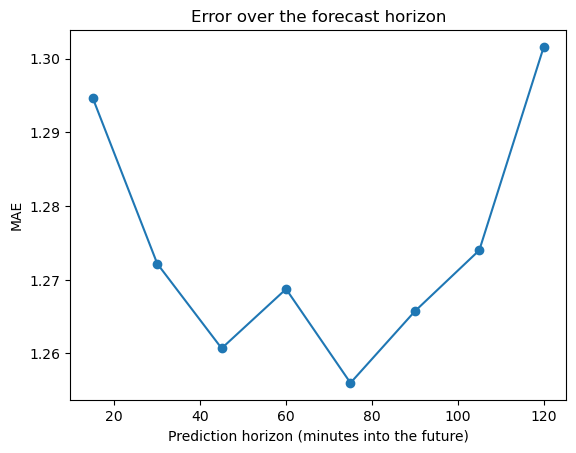

In [14]:
# Check whether the model error increases over the forecast horizon

# Calculate MAE for each prediction step (1 to 8)
mae_per_step = []
for step in range(y_test.shape[1]):   # 0...7, for 8 forecast steps
    mae = mean_absolute_error(y_test[:, step], y_pred[:, step])
    mae_per_step.append(mae)
    print(f"MAE for step {step+1} (t+{(step+1)*15}min): {mae:.2f}")

plt.plot(np.arange(1, 9)*15, mae_per_step, marker='o')
plt.xlabel("Prediction horizon (minutes into the future)")
plt.ylabel("MAE")
plt.title("Error over the forecast horizon")
plt.savefig("graphs/mae_over_horizon.png")  # statt plt.show()

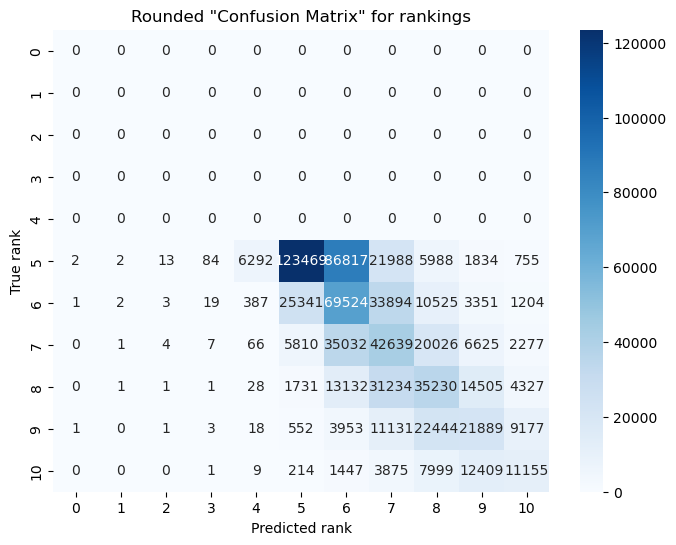

In [15]:
# Round both true and predicted values to the nearest integer rank
true_rounded = np.round(y_test.flatten())
pred_rounded = np.round(y_pred.flatten())

# Calculate the confusion matrix between the rounded true and predicted ranks
cm = confusion_matrix(true_rounded, pred_rounded)
plt.figure(figsize=(8,6))
sns.heatmap(cm[:11, :11], annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted rank")
plt.ylabel("True rank")
plt.title("Rounded \"Confusion Matrix\" for rankings")
plt.savefig("graphs/confusion_matrix.png") 
plt.show()

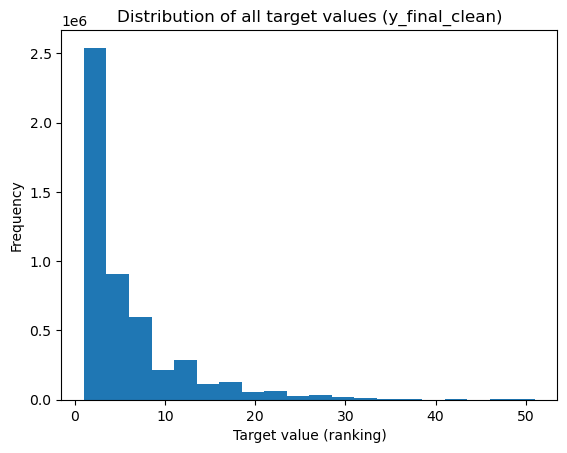

In [24]:
# Plot a histogram of all target values (flattened) to visualize their distribution
plt.hist(y_final_clean.flatten(), bins=20)
plt.title("Distribution of all target values (y_final_clean)")
plt.xlabel("Target value (ranking)")
plt.ylabel("Frequency")
plt.savefig("graphs/hist_y_final_clean.png") 
plt.show()

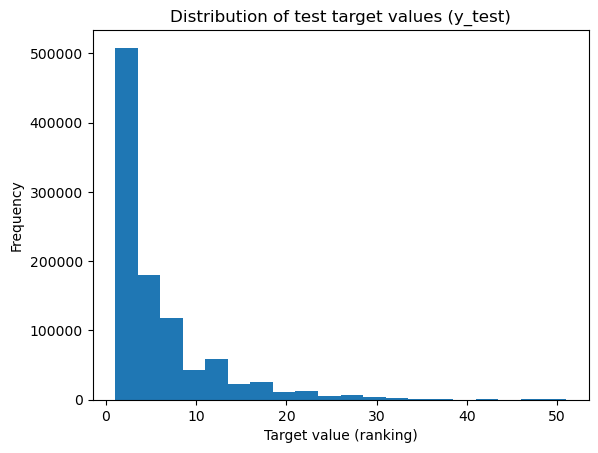

In [30]:
# Plot a histogram of the test target values to visualize their distribution
plt.clf()  # clear figure
plt.hist(y_test.flatten(), bins=20)
plt.title("Distribution of test target values (y_test)")
plt.xlabel("Target value (ranking)")
plt.ylabel("Frequency")
plt.savefig("graphs/hist_y_test_clean.png")
plt.show()

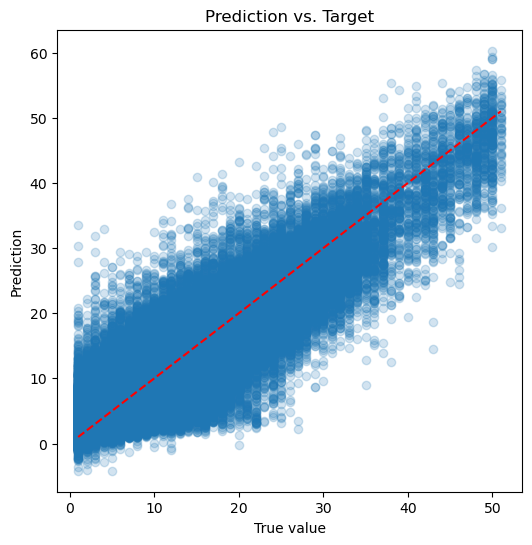

In [19]:
# Scatter plot: true values vs. predicted values to visualize prediction quality
plt.figure(figsize=(6,6))
plt.scatter(y_test.flatten(), y_pred.flatten(), alpha=0.2)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Ideal diagonal line
plt.xlabel("True value")
plt.ylabel("Prediction")
plt.title("Prediction vs. Target")
plt.savefig("graphs/scatter_plot.png") 
plt.show()

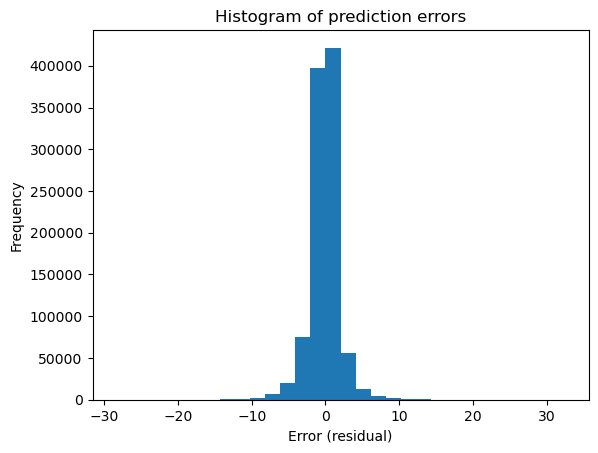

In [20]:
# Calculate and plot the histogram of prediction errors (residuals)
errors = y_pred.flatten() - y_test.flatten()
plt.hist(errors, bins=30)
plt.xlabel("Error (residual)")
plt.ylabel("Frequency")
plt.title("Histogram of prediction errors")
plt.savefig("graphs/prediction_errors.png") 
plt.show()

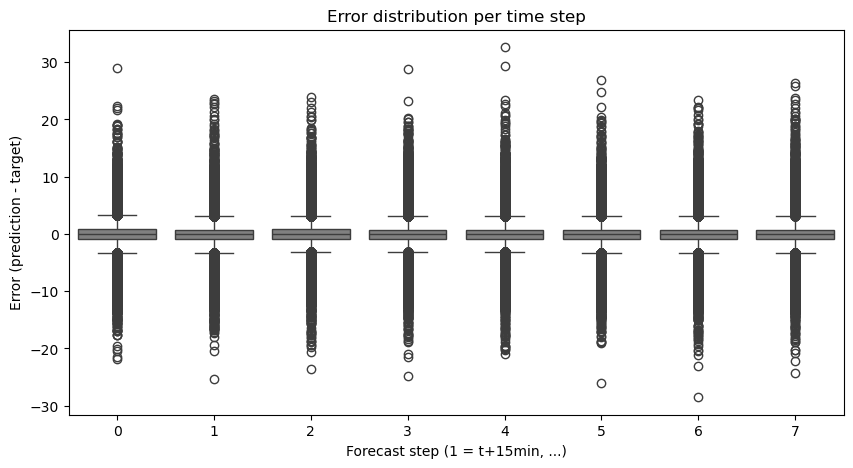

In [25]:
# Plot the error (prediction minus target) distribution for each forecast step using boxplots
errors_per_step = y_pred - y_test

# Plot
plt.figure(figsize=(10, 5))
sns.boxplot(data=errors_per_step, color='gray')  # <-- einheitliche Farbe hier
plt.xlabel("Forecast step (1 = t+15min, ...)")
plt.ylabel("Error (prediction - target)")
plt.title("Error distribution per time step")
plt.savefig("graphs/error_per_timestep.png")
plt.show()

In [22]:
# Minimum and maximum values in y_test (true targets)
print("Min/Max y_test:", np.nanmin(y_test), np.nanmax(y_test))

# Minimum and maximum values in y_pred (model predictions)
print("Min/Max y_pred:", np.nanmin(y_pred), np.nanmax(y_pred))

# Unique integer values in the rounded true targets
print("Unique rounded values in y_test:", np.unique(true_rounded))

# Unique integer values in the rounded predictions
print("Unique rounded values in y_pred:", np.unique(pred_rounded))

# Number of NaN values in y_test
print("Number of NaN in y_test:", np.isnan(y_test).sum())

# Number of NaN values in y_pred
print("Number of NaN in y_pred:", np.isnan(y_pred).sum())#

Min/Max y_test: 1.0 51.0
Min/Max y_pred: -4.177436 60.295525
Unique rounded values in y_test: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51.]
Unique rounded values in y_pred: [-4. -3. -2. -1.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13.
 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31.
 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49.
 50. 51. 52. 53. 54. 55. 56. 57. 59. 60.]
Number of NaN in y_test: 0
Number of NaN in y_pred: 0


In [28]:
# Create Table for Latex
# Example: y_test and y_pred are numpy arrays of shape (n_samples, 8)
# y_test = ...
# y_pred = ...

latex_rows = []

for step in range(y_test.shape[1]):  # 0...7
    y_true = y_test[:, step]
    y_pred_step = y_pred[:, step]

    mae = mean_absolute_error(y_true, y_pred_step)
    mse = mean_squared_error(y_true, y_pred_step)
    rmse = np.sqrt(mse)  # manually calculated
    r2 = r2_score(y_true, y_pred_step)
    corr = np.corrcoef(y_true, y_pred_step)[0, 1]

    time_step = f"t + {(step + 1) * 15}\,min"
    latex_row = f"{time_step} & {mae:.3f} & {rmse:.3f} & {r2:.3f} & {corr:.3f} \\\\"
    latex_rows.append(latex_row)

# Assemble LaTeX table with evenly distributed column widths
latex_table = r"""\begin{table}[ht]
\centering
\caption{Evaluation Metrics per Forecast Horizon}
\label{tab:evaluation_metrics}
\begin{tabularx}{\textwidth}{X X X X X}
\toprule
\textbf{Time Step} & \textbf{MAE} & \textbf{RMSE} & \textbf{R\textsuperscript{2}} & \textbf{Correlation} \\
\midrule
""" + "\n".join(latex_rows) + r"""
\bottomrule
\end{tabularx}
\end{table}
"""

print(latex_table)

\begin{table}[ht]
\centering
\caption{Evaluation Metrics per Forecast Horizon}
\label{tab:evaluation_metrics}
\begin{tabularx}{\textwidth}{X X X X X}
\toprule
\textbf{Time Step} & \textbf{MAE} & \textbf{RMSE} & \textbf{R\textsuperscript{2}} & \textbf{Correlation} \\
\midrule
t + 15\,min & 1.295 & 2.010 & 0.881 & 0.939 \\
t + 30\,min & 1.272 & 1.985 & 0.885 & 0.941 \\
t + 45\,min & 1.261 & 1.958 & 0.889 & 0.943 \\
t + 60\,min & 1.269 & 1.985 & 0.886 & 0.941 \\
t + 75\,min & 1.256 & 1.965 & 0.888 & 0.942 \\
t + 90\,min & 1.266 & 1.971 & 0.887 & 0.942 \\
t + 105\,min & 1.274 & 1.983 & 0.885 & 0.941 \\
t + 120\,min & 1.302 & 2.032 & 0.878 & 0.937 \\
\bottomrule
\end{tabularx}
\end{table}



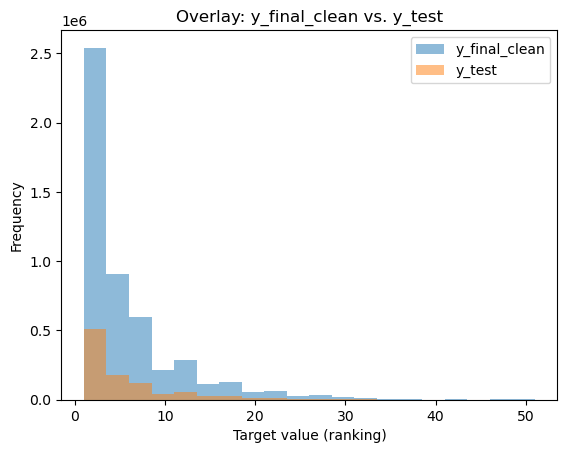

In [3]:
# Test for overlay between y_final_clean and y_test

plt.hist(y_final_clean.flatten(), bins=20, alpha=0.5, label='y_final_clean')
plt.hist(y_test.flatten(), bins=20, alpha=0.5, label='y_test')
plt.title("Overlay: y_final_clean vs. y_test")
plt.xlabel("Target value (ranking)")
plt.ylabel("Frequency")
plt.legend()
plt.show()
